In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import random

class DataLoader():
    def __init__(self, filepath):
        cwd = os.getcwd()
        self.basepath = filepath
        try:
            os.stat(self.basepath+"/add_prim_split")
            os.stat(self.basepath+"/few_shot_split")
            os.stat(self.basepath+"/filler_split")
            os.stat(self.basepath+"/length_split")
            os.stat(self.basepath+"/simple_split")
            os.stat(self.basepath+"/template_split")
        except Exception as e:
            raise Exception("Path "+filepath+" doesnt seem to contain the required folders.")

    def load_1a(self):
        train = self.file_loader("/simple_split/tasks_train_simple.txt")
        test = self.file_loader("/simple_split/tasks_test_simple.txt")

        return (np.asarray(train), np.asarray(test))

    def load_1b(self):
        percentile_dict = {}
        splits = ["1", "2", "4", "8", "16", "32", "64"]

        for percentile in splits:
            train = self.file_loader("/simple_split/size_variations/tasks_train_simple_p{}.txt".format(percentile))
            test = self.file_loader("/simple_split/size_variations/tasks_test_simple_p{}.txt".format(percentile))
            
            percentile_dict[percentile] = (np.asarray(train), np.asarray(test))
            
        return percentile_dict

    def load_2(self):
        train = self.file_loader("/length_split/tasks_train_length.txt")
        test = self.file_loader("/length_split/tasks_test_length.txt")

        return (np.asarray(train), np.asarray(test))

    def load_3(self):
        """
        loads the datasets for both parts of the experiment
        the first part where both primitives appear without compositional commands
        the second part where 'jump' primitive appears in
        compositional commands of varying lengths
        returns a dictionary of pairs all possible train/test sets
        """
        data_dict = {}
        nums = ["1", "2", "4", "8", "16", "32"]
        reps = ["1", "2", "3", "4", "5"]

        train = self.file_loader("/add_prim_split/tasks_train_addprim_jump.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_jump.txt")
        data_dict['jump'] = (np.asarray(train), np.asarray(test))

        train = self.file_loader("/add_prim_split/tasks_train_addprim_turn_left.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_turn_left.txt")
        data_dict['lturn'] = (np.asarray(train), np.asarray(test))
        
        for num in nums:
            for rep in reps:
                train = self.file_loader("/add_prim_split/with_additional_examples/tasks_train_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                test = self.file_loader("/add_prim_split/with_additional_examples/tasks_test_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                
                data_dict['jump_num{}_rep{}'.format(num, rep)] = (np.asarray(train), np.asarray(test))
            
        return data_dict

    def file_loader(self, path):
        sent_list = []
        with open(self.basepath+path, "r") as f:
                    for line in f:
                        sent_list.append(line_splitter(line))
        return sent_list

    
def line_splitter(sentence):
    sent_list = sentence.split("OUT: ")
    sent_list[0] = sent_list[0].strip("IN: ")
    sent_list[1] = sent_list[1].strip("\n")

    return sent_list

# examples:
# 1a :
#   train, test = dl.load_1a()
#   train[0][0] first train sentence, "IN"
#   train[0][1] first train sentence, "OUT"
# 1b :
#   dict = dl.load_1b()
#   train, test = dict["1"] extract the 1 percentile sentences out, split into train and test
#   train[0][0] first train sentence, "OUT"
#   train[0][1] first train sentence, "OUT"
#
# all returns are numpy arrays


In [0]:
#from data_loader import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SOS_token = 0
EOS_token = 1

class Input:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 1  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class Output:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 2  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


        
def get_embedding(word, lookup_dict, embeds):
    tensor = torch.tensor([lookup_dict[word]], dtype=torch.long)
    return embeds(tensor)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [0]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomLoss(torch.autograd.Function):  
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return

    @staticmethod
    def backward(ctx, grad_output):
        import ipdb; ipdb.set_trace()
        #pass
        return

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.0, layers=1, mode='RNN'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        output, hidden = self.hidden_layer(output, hidden)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.0, layers=1, attention=False, mode='RNN'):
    	#layers should be either 1 or 2
    	#in the latter case remember to pass a pair of hidden states!
    	#mode can be either 'LSTM', 'GRU' or 'RNN'
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        self.max_length = max_length
        self.attention = attention

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        if self.attention:
	        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
	        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        if self.attention:
	        attn_weights = F.softmax(
	            self.attn(torch.cat((output[0], hidden[0][0]), 1)), dim=1)
	        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
	        output = torch.cat((output[0], attn_applied[0]), 1)
        	output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.hidden_layer(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden

def train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, clipping_value=5, mode='RNN'):
    encoder_hidden1 = encoder.initHidden()
    encoder_hidden2 = encoder.initHidden()

    encoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        if mode == 'LSTM':
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei], (encoder_hidden1, encoder_hidden2))
        else: 
            encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden1 = encoder_hidden1
    decoder_hidden2 = encoder_hidden2

    forcing = random.random() > 0.5

    if forcing:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            decoder_input = output_tensor[di]
            loss += criterion(decoder_output, output_tensor[di])

            if decoder_input.item() == EOS_token:
                break
    else:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, output_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break

    #loss = CustomLoss
    loss.backward()

    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping_value)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping_value)

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / output_length

    
def trainIters(encoder, decoder, train_data, input_lang, output_lang, max_length, learning_rate=0.001, mode='RNN'):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    losses = []
    print(train_data.shape[0])
    print_loss_total = 0

    for iter in range(train_data.shape[0]):
        training_pair = tensorsFromPair(train_data[iter], input_lang, output_lang)
        input_tensor = training_pair[0]
        output_tensor = training_pair[1]

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            output_tensor = output_tensor.cuda()
        
        loss = train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, mode=mode)
        losses.append(loss)
        print_loss_total += loss

        if iter % 500 == 0:
            print_loss_avg = print_loss_total / 500
            print(iter)
            print(print_loss_avg)
            print_loss_total = 0

    return losses

dl = DataLoader("/content/drive/My Drive/Colab Notebooks/SCAN")
#dl = DataLoader("SCAN")

#train_data, test_data = dl.load_1a()
data_dict = dl.load_1b()

splits = ["1", "2", "4", "8", "16", "32", "64"]

'''
train_data_1, test_data_1 = data_dict["1"]
train_data_2, test_data_2 = data_dict["2"]
train_data_4, test_data_4 = data_dict["4"]
train_data_8, test_data_8 = data_dict["8"]
train_data_16, test_data_16 = data_dict["16"]
train_data_32 test_data_32 = data_dict["32"]
train_data_64, test_data_64 = data_dict["64"]
'''

#MAX_LENGTH = max([len(x[0].split()) for x in train_data]) + 1
MAX_LENGTH = 100

lang_dict = {}

for split in splits:
  lang_dict["train_in_"+split] = Input("train_input_"+split)
  lang_dict["train_out_"+split] = Output("train_output_"+split)
  lang_dict["test_in_"+split] = Input("test_input_"+split)
  lang_dict["test_out_"+split] = Output("test_output_"+split)

'''
train_in = Input("train_input")
train_out = Output("train_output")

test_in = Input("test_input")
test_out = Output("test_output")
'''

for split in splits:
  train_data,test_data = data_dict[split]
  for datapoint in train_data:
          lang_dict["train_in_"+split].addSentence(datapoint[0])
          lang_dict["train_out_"+split].addSentence(datapoint[1])

  for datapoint in test_data:
          lang_dict["test_in_"+split].addSentence(datapoint[0])
          lang_dict["test_out_"+split].addSentence(datapoint[1])

In [0]:
train_data_test, test_data_test = data_dict["1"]

In [76]:
train_data_test[0]

array(['jump opposite right twice and turn opposite right thrice',
       'I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT'],
      dtype='<U455')

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

train_data = train_data[np.random.choice(train_data.shape[0], 100000, replace=True), :]

def train_and_save(model, dropout, att, layers, model_name):
    encoder = Encoder(train_in.n_words, 200, layers=layers, mode=model, dropout_p=dropout)
    decoder = Decoder(200, train_out.n_words, layers=layers, max_length=MAX_LENGTH, mode=model, dropout_p=dropout, attention=att)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    losses = trainIters(encoder, decoder, train_data, train_in, train_out, MAX_LENGTH, mode=model)
    plt.plot(losses)
    plt.title(model+'_layers='+str(layers)+'_drop='+str(dropout)+'_attention='+str(att))
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    torch.save(encoder.state_dict(), "/content/drive/My Drive/"+model_name+"_encoder.pt")
    torch.save(decoder.state_dict(), "/content/drive/My Drive/"+model_name+"_decoder.pt")

30000
0
0.004159884712912819
500
1.5738222190923563
1000
1.01875218774315
1500
0.6882623159278619
2000
0.5963558615379919
2500
0.530949799348667
3000
0.43277487046472873
3500
0.39760076227939656
4000
0.3083820516165601
4500
0.34996710250217317
5000
0.313941540263295
5500
0.2220824987940729
6000
0.21449277227146135
6500
0.21137796340782525
7000
0.19213516520676222
7500
0.1662076080163937
8000
0.14828307961569706
8500
0.16225096810966788
9000
0.12752832457243843
9500
0.08949467912290246
10000
0.12533550576513178
10500
0.09479370467376765
11000
0.10980401684176003
11500
0.08314503412068101
12000
0.06360003386814149
12500
0.07883179631970659
13000
0.08452450764626543
13500
0.0759088278149141
14000
0.06682923610935364
14500
0.0709308142944118
15000
0.08916552894269171
15500
0.09020297113811225
16000
0.04693329466332992
16500
0.0571551179733155
17000
0.08060473948413947
17500
0.03562725544693731
18000
0.026731629130538302
18500
0.04464385929265965
19000
0.04547590917126005
19500
0.0472085778

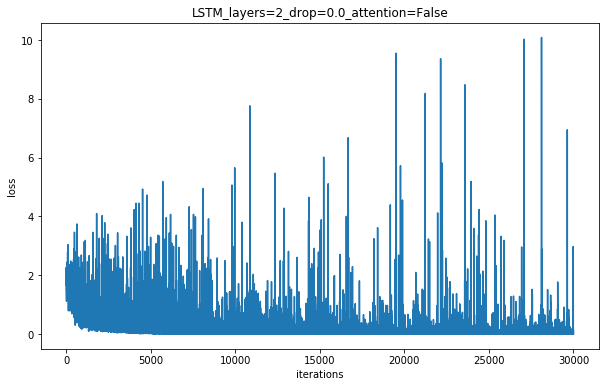

In [42]:
model='LSTM'
for split in splits:
  train_data, test_data = data_dict[split]
  print(len(train_data))
  print(len(test_data))
  train_data = train_data[np.random.choice(train_data.shape[0], 100000, replace=True), :]
  train_and_save(model, train_data, dropout=0.0, att=False, layers=2, model_name='LSTM_2nd_exercise_split_'+split)

In [50]:
encoder = Encoder(train_in.n_words, 200, layers=2, mode="LSTM", dropout_p=0.0)
encoder.load_state_dict(torch.load("/content/drive/My Drive/LSTM_no_drop_no_att_30k_encoder.pt"))
encoder.eval()

decoder = Decoder(200, train_out.n_words, layers=2, max_length=MAX_LENGTH, mode="LSTM", dropout_p=0.0, attention=False)
decoder.load_state_dict(torch.load("/content/drive/My Drive/LSTM_no_drop_no_att_30k_decoder.pt"))
decoder.eval()

Decoder(
  (embedding): Embedding(8, 200)
  (dropout): Dropout(p=0.0, inplace=False)
  (hidden_layer): LSTM(200, 200, num_layers=2)
  (out): Linear(in_features=200, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

In [51]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *
#from layers_attempt import *

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")

def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=100):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        #if torch.cuda.is_available():
        #    input_tensor = input_tensor.cuda()
        input_length = input_tensor.size()[0]
        encoder_hidden1 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)
        encoder_hidden2 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei],
                                                     (encoder_hidden1, encoder_hidden2))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden1 = encoder_hidden1
        decoder_hidden2 = encoder_hidden2

        decoded_words = []
        for di in range(max_length):
          if decoder.attention:
            decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs[:10]) # needs to only have the 10 in the encoder outputs?
          else:
            decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
          topv, topi = decoder_output.data.topk(1)
          if topi.item() == EOS_token:
              #decoded_words.append('<EOS>')
              break
          else:
            decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return decoded_words

def evaluateIters(test_data, encoder, decoder, lang_in, lang_out):
    hit = 0
    miss = 0
    iters = 0
    hit_idx = []
    miss_idx = []

    for idx, test_point in enumerate(test_data):
        pred = evaluate(encoder, decoder, test_point[0], lang_in, lang_out)
        pred = " ".join(pred)
        if pred == test_point[1]:
            hit += 1
            hit_idx.append(idx)
        else:
            miss += 1
            miss_idx.append(idx)
        iters += 1

        if iters % 100 == 0:
            print(iters)
            print(hit)

    return hit, hit_idx, miss, miss_idx

hit, hit_idx, miss, miss_idx = evaluateIters(test_data, encoder, decoder, train_in, train_out)

100
80
200
153
300
236
400
309
500
391
600
465
700
544
800
634
900
711
1000
790
1100
871
1200
951
1300
1029
1400
1105
1500
1184
1600
1270
1700
1350
1800
1426
1900
1499
2000
1572
2100
1657
2200
1727
2300
1807
2400
1890
2500
1965
2600
2047
2700
2132
2800
2211
2900
2288
3000
2367
3100
2441
3200
2513
3300
2588
3400
2672
3500
2755
3600
2839
3700
2909
3800
2986
3900
3068
4000
3143
4100
3217


In [52]:
1-miss/test_data.shape[0]

0.7847919655667145

In [0]:
idx=50
print(test_data[miss_idx[idx]][0].split())
print(evaluate(encoder, decoder, test_data[miss_idx[idx]][0], train_in, train_out))
print(len(evaluate(encoder, decoder, test_data[miss_idx[idx]][0], train_in, train_out)))
print(test_data[miss_idx[idx]][1].split())

['run', 'twice', 'after', 'jump', 'around', 'left']
['I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_RUN', 'I_RUN', 'I_RUN']
10
['I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_RUN', 'I_RUN']


In [0]:
test_data[4000][0]

'turn left thrice after turn opposite right twice'

In [0]:
max([len(x[0].split()) for x in train_data])

9

In [0]:
str(True)

'True'